# Example #3 Housing Prediction: Chapter 3

Example of regression.

## CPU/GPU Config

Using a GPU for this example is slower than using a CPU (on my system).
The batch size used for training is very low (the number of features is low too) and prevents you from being able to use the GPU effectively.

Some sample average runtimes for training with different batch sizes.

    [With CPU - Batch Size 1]       0 days 00:01:23.265555
    [With CPU - Batch Size 5]       0 days 00:00:17.589785
    [With CPU - Batch Size 10]      0 days 00:00:09.513331
    [With CPU - Batch Size 100]     0 days 00:00:02.192333
    
    [With GPU - Batch Size 1]       0 days 00:04:21.741343
    [With GPU - Batch Size 5]       0 days 00:00:54.128071
    [With GPU - Batch Size 10]      0 days 00:00:28.202666
    [With GPU - Batch Size 100]     0 days 00:00:04.780666

In [1]:
# Force use of CPU - This sample is faster than using a GPU for a small batch size.
# This needs to be done before importing keras or tensorflow.

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import datetime as dt
import pandas as pd
import numpy as np

from keras import models
from keras import layers
from keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns

from keras.datasets import boston_housing

Using TensorFlow backend.


## Basic Helpers

In [3]:
def get_time():
    return dt.datetime.now().strftime('%H:%M:%S.%f')

# Load Data

In [4]:
# Get the feature names from the original dataset description.

# http://lib.stat.cmu.edu/datasets/boston
variable_description = """
     CRIM     per capita crime rate by town
     ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
     INDUS    proportion of non-retail business acres per town
     CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
     NOX      nitric oxides concentration (parts per 10 million)
     RM       average number of rooms per dwelling
     AGE      proportion of owner-occupied units built prior to 1940
     DIS      weighted distances to five Boston employment centres
     RAD      index of accessibility to radial highways
     TAX      full-value property-tax rate per $10,000
     PTRATIO  pupil-teacher ratio by town
     B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
     LSTAT    % lower status of the population
     MEDV     Median value of owner-occupied homes in $1000's
"""

variables = []
for line in variable_description.split("\n"):
    parts = line.strip().split()
    if len(parts) >= 1:
        variables.append(parts[0])
        
def make_df(data, targets):
    df = pd.DataFrame(data=data, columns=variables[0:13])
    df[variables[13]] = targets
    return df

In [5]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

train_data_df = make_df(train_data, train_targets)
test_data_df = make_df(test_data, test_targets)

## Explore Data

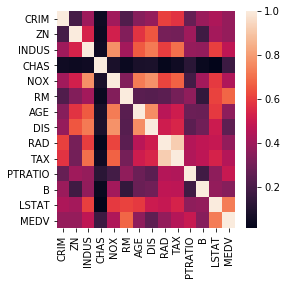

In [6]:
# View feature correlation

td_corr = train_data_df.corr().abs()
plt.figure(figsize = (4,4))
sns.heatmap(td_corr, annot=False)
plt.show()

In [7]:
td_corr[['MEDV']].sort_values(by='MEDV', ascending=False).head(10)

,MEDV
MEDV,1.000000
LSTAT,0.730793
RM,0.681483
PTRATIO,0.493990
INDUS,0.476743
TAX,0.448737
NOX,0.438328
ZN,0.380299
CRIM,0.378498
RAD,0.375515


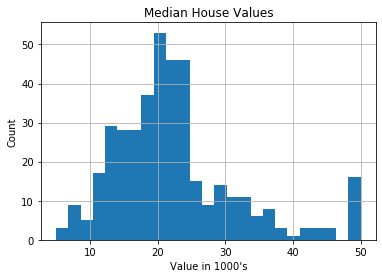

In [8]:
plt.hist(train_targets, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

## Prepare Data

In [9]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)

def normalize(data):
    return (data - mean) / std

train_data_df_norm = normalize(train_data_df.loc[:,variables[0:13]])
train_data_df_norm[variables[13]] = train_data_df[variables[13]]

test_data_df_norm = normalize(test_data_df.loc[:,variables[0:13]])
test_data_df_norm[variables[13]] = test_data_df[variables[13]]

## Train Model

In [10]:
def k_validation_splits(df, k):
    k_s = np.random.randint(0, k, len(df))
    for k_i in range(k):
        yield((k_i + 1, df[k_s == k_i], df[k_s != k_i]))
        
def k_validation_train(df, k, fn, verbose=True):
    results = []
    for k_i, val_df, train_df in k_validation_splits(df, k):
        start_t = dt.datetime.now()
        results.append(fn(val_df, train_df))
        end_t = dt.datetime.now()
        exec_t = end_t - start_t
        if verbose:
            print(f"Processing of fold {k_i} took: {exec_t}.")
    return results

In [11]:
num_epochs = 200
batch_size = 1

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(len(variables) - 1,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

def train_k(val_data, train_data):
    train_x = train_data[variables[0:13]]
    train_y = train_data[variables[13]]
    val_x = val_data[variables[0:13]]
    val_y = val_data[variables[13]]

    model = build_model()
    return model.fit(
        train_x,
        train_y,
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=0,
        validation_data=(val_x, val_y)
    )

histories = k_validation_train(train_data_df_norm, 4, train_k)

Processing of fold 1 took: 0:01:22.997413.
Processing of fold 2 took: 0:01:22.686577.
Processing of fold 3 took: 0:01:25.303874.
Processing of fold 4 took: 0:01:19.889556.


In [12]:
def history_to_df(h):
    h_df = pd.DataFrame(h.history)
    h_df['epoch'] = h_df.index.values + 1
    return h_df

history = pd.concat(history_to_df(h) for h in histories)
h_avgs = history.groupby('epoch').mean()

In [13]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

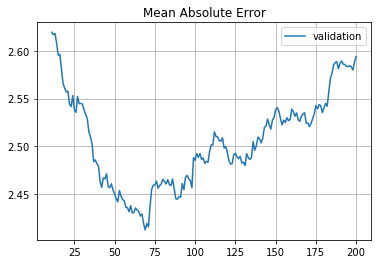

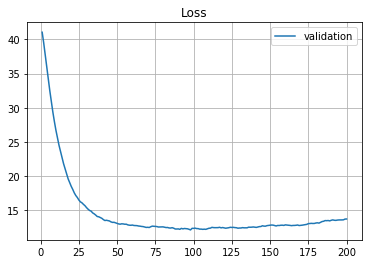

In [14]:
#plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.mae[10:]), "-", label="train")
plt.plot(h_avgs.index[10:], smooth_curve(h_avgs.val_mae[10:]), "-", label="validation")
plt.grid()
plt.title("Mean Absolute Error")
plt.legend()
plt.show()

#plt.plot(h_avgs.index, h_avgs.loss, "-", label="train")
plt.plot(h_avgs.index, smooth_curve(h_avgs.val_loss), "-", label="validation")
plt.grid()
plt.title("Loss")
plt.legend()
plt.show()

## Train Model

In [15]:
model = build_model()
num_epochs = 80
model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]],
    epochs=num_epochs,
    batch_size=batch_size,
    verbose=0
)

## Evaluate Test Results

In [16]:
val_mse, val_mae = model.evaluate(
    test_data_df_norm[variables[0:13]],
    test_data_df_norm[variables[13]],
    verbose=0)

print(val_mse)
print(val_mae)

17.772428923962163
2.471842050552368


In [17]:
test_data_df['Predicted'] = [r[0] for r in model.predict(test_data_df_norm[variables[0:13]])]

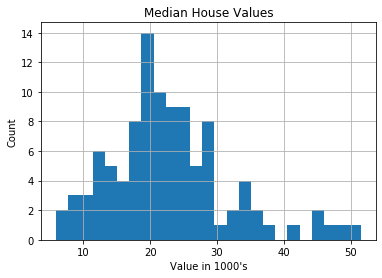

In [18]:
plt.hist(test_data_df.Predicted, bins=25)
plt.title("Median House Values")
plt.xlabel("Value in 1000's")
plt.ylabel("Count")
plt.grid()
plt.show()

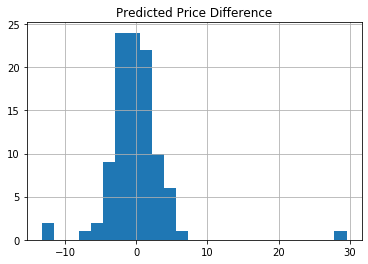

In [19]:
plt.hist(test_data_df.Predicted - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()

## See How XGBoost Compares

In [20]:
import xgboost as xgb
import sklearn.metrics
from sklearn.model_selection import train_test_split

In [21]:
def combinations(**params):
    p_list = list(params.items())
    results = []
    
    def gen(p_current, i):
        if i >= len(p_list):
            results.append(p_current)
            return
        else:
            key, vals = p_list[i]
            for v in vals:
                p_next = p_current.copy()
                p_next[key] = v
                gen(p_next, i+1)
    
    gen({}, 0)
    return results

In [22]:
def xgb_train(model_params):
    def xgb_train_k(val_data, train_data):
        train_x = train_data[variables[0:13]]
        train_y = train_data[variables[13]].values
        val_x = val_data[variables[0:13]]
        val_y = val_data[variables[13]].values

        xgb_model = xgb.XGBRegressor(**model_params)
        xgb_model.fit(train_x, train_y)
        xgb_results = xgb_model.predict(train_x)
        mae = sklearn.metrics.mean_absolute_error(train_y, xgb_results)

        xgb_results_val = xgb_model.predict(val_x)
        val_mae = sklearn.metrics.mean_absolute_error(val_y, xgb_results_val)
        return (mae, val_mae)
    
    val_metrics = k_validation_train(train_data_df_norm, 4, xgb_train_k, verbose=False)
    mae = np.mean([x[0] for x in val_metrics])
    val_mae = np.mean([x[1] for x in val_metrics])
    
    xgb_train_stat = model_params.copy()
    xgb_train_stat['mae'] = mae
    xgb_train_stat['val_mae'] = val_mae
    return xgb_train_stat

def xgb_train_with_params(param_sets):
    xgb_train_param_stats = pd.DataFrame(xgb_train(model_params) for model_params in param_sets)
    xgb_train_param_stats = xgb_train_param_stats.sort_values(by='val_mae', ascending=True)
    return xgb_train_param_stats
    
xgb_train_results = xgb_train_with_params(combinations(
    max_depth     = [2, 5, 7, 10],
    n_estimators  = [100, 200, 300, 500],
    learning_rate = [0.1, 0.2, 0.3, 0.4],
    alpha         = [5],
    objective     = ['reg:squarederror'],
))

display(xgb_train_results.head(5))
display(xgb_train_results.corr()[['val_mae']])

,max_depth,n_estimators,learning_rate,alpha,objective,mae,val_mae
56,10,300,0.1,5,reg:squarederror,0.000743,2.060750
60,10,500,0.1,5,reg:squarederror,0.000736,2.100975
20,5,200,0.1,5,reg:squarederror,0.128931,2.118735
37,7,200,0.2,5,reg:squarederror,0.000828,2.135054
45,7,500,0.2,5,reg:squarederror,0.000847,2.135777


,val_mae
max_depth,-0.217529
n_estimators,0.001812
learning_rate,0.489168
alpha,NaN
mae,0.218160
val_mae,1.000000


In [23]:
chosen_params = xgb_train_results.drop(columns=['mae', 'val_mae']).iloc[0].to_dict()
chosen_params

{'max_depth': 10,
 'n_estimators': 300,
 'learning_rate': 0.1,
 'alpha': 5,
 'objective': 'reg:squarederror'}

In [24]:
# Train model with chosen hyper parameters all the entire training set.
xgb_model = xgb.XGBRegressor(**chosen_params)

xgb_model.fit(
    train_data_df_norm[variables[0:13]],
    train_data_df_norm[variables[13]].values
)

# Show test metrics
xgb_t_results = xgb_model.predict(test_data_df_norm[variables[0:13]])
test_mae = sklearn.metrics.mean_absolute_error(test_data_df_norm[variables[13]].values, xgb_t_results)
print(f"Test MAE: {test_mae}")

Test MAE: 2.2792487780253095


In [25]:
# Show features by importance
features = pd.DataFrame()
features['name'] = variables[0:13]
features['importance'] = xgb_model.feature_importances_
features = features.sort_values(by='importance', ascending=False)
features

,name,importance
12,LSTAT,0.589673
5,RM,0.202710
7,DIS,0.059945
4,NOX,0.049403
9,TAX,0.033828
10,PTRATIO,0.016135
0,CRIM,0.015147
8,RAD,0.011875
11,B,0.007915
6,AGE,0.006466


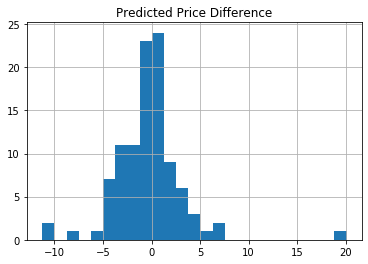

In [26]:
plt.hist(xgb_t_results - test_data_df.MEDV, bins=25)
plt.title("Predicted Price Difference")
plt.grid()
plt.show()